# Load data

In [ ]:
from pathlib import Path
from datasets import DatasetDict


dataPath = Path("tiny-imagenet")
if dataPath.exists() is False:
    from datasets import load_dataset

    ds: DatasetDict = load_dataset("zh-plus/tiny-imagenet")  # type: ignore
    ds.save_to_disk(dataPath)  # type: ignore

else:
    from datasets import load_from_disk

    ds: DatasetDict = load_from_disk(dataPath)  # type: ignore

assert isinstance(ds, DatasetDict)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


A look at some images

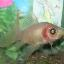

In [ ]:
ds["train"][0]["image"]

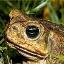

In [11]:
ds["train"][1500]["image"]

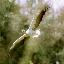

In [12]:
ds["valid"][900]["image"]

The properties of the images

In [13]:
img = ds["train"][0]["image"]

print(f"Size = {img.size}")
print(f"Mode = {img.mode}")
print(f"Format = {img.format}")

Size = (64, 64)
Mode = RGB
Format = JPEG


# Dataset

Prepare data for training and evaluating.

Also augment the train data by introduce random effects like cropting, rotating, flip.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.transforms import functional as ImgF


# ds["train"][0]["image"] is a PIL.JpegImagePlugin.JpegImageFile
class ImageDataset(Dataset):
    """Dataset of images and its labels. Return image and label. If transform is provided, apply it to the image.

    Args:
        Dataset (_type_): _description_
    """

    IMG_SIZE = 64, 64

    def transformBuild(self, normaliser):
        transformations = []
        transformations.append(v2.Resize(size=ImageDataset.IMG_SIZE))
        if self.randCrop:
            transformations.append(
                v2.RandomResizedCrop(size=ImageDataset.IMG_SIZE, scale=(0.8, 1.0))
            )
        if self.randRot:
            transformations.append(v2.RandomRotation(30))  # type: ignore
        if self.randFlipH:
            transformations.append(v2.RandomHorizontalFlip())
        if self.randFlipV:
            transformations.append(v2.RandomVerticalFlip())

        transformations.append(v2.ToTensor())
        transformations.append(normaliser)

        return v2.Compose(transformations)

    def __init__(
        self,
        data,
        randCrop=False,
        randRot=False,
        randFlipH=False,
        randFlipV=False,
        normaliser=None,
    ):
        self.randCrop = randCrop
        self.randRot = randRot
        self.randFlipH = randFlipH
        self.randFlipV = randFlipV

        self.length = len(data)
        self.imgSize = self.IMG_SIZE

        self.images = [d["image"] for d in data]
        self.labels = [d["label"] for d in data]

        # calculate normaliser if not provided
        if normaliser is None:
            mean = torch.zeros(3)
            std = torch.zeros(3)

            for img in self.images:
                img = ImgF.to_tensor(img)
                mean += img.mean(dim=(0, 1, 2))
                std += img.std(dim=(0, 1, 2))

            mean /= self.length
            std /= self.length

            normaliser = v2.Normalize(mean.tolist(), std.tolist())
        self.normaliser = normaliser    

        # build the transformer
        self.imgTransformer = self.transformBuild(normaliser)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.imgTransformer(self.images[idx]), self.labels[idx]

# CNN

## DataLoader

In [17]:
from torch.utils.data import DataLoader

trainSet = ImageDataset(ds["train"], True, True, True, True, None)
testSet = ImageDataset(ds["valid"], normaliser=trainSet.normaliser)

trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False, pin_memory=True)

/tmp/ipykernel_583887/1926706976.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean += torch.tensor(img).mean(dim=(0, 1, 2))
/tmp/ipykernel_583887/1926706976.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std += torch.tensor(img).std(dim=(0, 1, 2))
/home/tu/micromamba/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [22]:
trainSet[0][0].size()

torch.Size([3, 64, 64])

## Model

In [29]:
from torch import nn
from torch.nn import functional as F


class SimpleCnn(nn.Module):
    def __init__(self):
        super(SimpleCnn, self).__init__()        
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 200)
        
        pass
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.3)
        
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
model = SimpleCnn()
sampleIn = torch.randn(1, 3, 64, 64)
print(f"test output shape {model(sampleIn).shape}")

del model
del sampleIn

test output shape torch.Size([1, 200])


## Training Loop

In [30]:
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    trainLoss = 0.0

    for batch_idx, (inputs, labels) in enumerate(trainLoader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

        # Print every 100 batches
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(trainLoader)}], Loss: {loss.item():.4f}"
            )

    # Average loss for the epoch
    print(
        f"Epoch [{epoch+1}/{n_epochs}] - Average Loss: {trainLoss / len(trainLoader):.4f}"
    )

Epoch [1/10], Step [0/1563], Loss: 5.2982
Epoch [1/10], Step [100/1563], Loss: 5.3069
Epoch [1/10], Step [200/1563], Loss: 5.2912
Epoch [1/10], Step [300/1563], Loss: 5.3069


KeyboardInterrupt: 